In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
from matplotlib import pyplot as plt
import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/train.csv
./data/test.csv


# Dataset:
Input variables:

   **# bank client data:**
   
   1 - ID : ID of client
   
   2 - age (numeric)
   
   3 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   
   4 - marital : marital status (categorical: "divorced","married","single"; note: "divorced" means divorced or widowed)
   
   5 - education (categorical: "primary","secondary","tertiary,"unknown")
   
   6 - default: has credit in default? (categorical: "no","yes")
   
   7 - balance : has money in account? (numeric)
   
   8 - housing: has housing loan? (categorical: "no","yes")
   
   9 - loan: has personal loan? (categorical: "no","yes")
   
   10 - contact: contact communication type (categorical: "cellular","telephone") 
   
   11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   
   12 - day: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
   
   13 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   
   14 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   
   15 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)
   
   16 - previous: number of contacts performed before this campaign and for this client (numeric)
   
   17 - poutcome: outcome of the previous marketing campaign (categorical: "failure","unknown","other","success")
   
  
   **Output variable (desired target):**
   
   18 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [34]:
train = pd.read_csv("./data/train.csv", sep=";")
test = pd.read_csv("./data/test.csv", sep=";")

In [35]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


# **1.Filling NaN(unknown) Values:**

In [37]:
train.isna().sum() , test.isna().sum()

(age          0
 job          0
 marital      0
 education    0
 default      0
 balance      0
 housing      0
 loan         0
 contact      0
 day          0
 month        0
 duration     0
 campaign     0
 pdays        0
 previous     0
 poutcome     0
 y            0
 dtype: int64,
 age          0
 job          0
 marital      0
 education    0
 default      0
 balance      0
 housing      0
 loan         0
 contact      0
 day          0
 month        0
 duration     0
 campaign     0
 pdays        0
 previous     0
 poutcome     0
 y            0
 dtype: int64)

In [38]:
train.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

* **FILLING UNKNOWN VALUES :**
It's look like dataset has no NaN values but dataset has "unknown" values.

In [39]:
train["job"].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

Filling unknown job values with mode value but also we can fill unknown job values with mode of education degree per job.
So babsically here we are assuming a direct relation between education degree and job. So below we have calculated the probability of a job depending on the education.

In [40]:
eduRatio = pd.DataFrame({'Job' : []})
for i in train["job"].unique():
    eduRatio = eduRatio.append(train[(train["job"] == i)]["education"].value_counts().to_frame().iloc[0] * 100 / train[(train["job"] == i)]["education"].value_counts().sum())
eduRatio["Job"] = train["job"].unique()
eduRatio

,Job,education
tertiary,management,82.480440
secondary,technician,68.829801
tertiary,entrepreneur,46.133154
secondary,blue-collar,55.189067
unknown,unknown,44.097222
secondary,retired,43.462898
secondary,admin.,81.589635
secondary,services,83.220992
tertiary,self-employed,52.754908
secondary,unemployed,55.871067


In [41]:
train.loc[(train.job == "unknown") & (train.education == "secondary"),"job"] = "services"
train.loc[(train.job == "unknown") & (train.education == "primary"),"job"] = "housemaid"
train.loc[(train.job == "unknown") & (train.education == "tertiary"),"job"] = "management"
train.loc[(train.job == "unknown"),"job"] = "blue-collar"

In [42]:
train["job"].value_counts()

blue-collar      9859
management       9497
technician       7597
admin.           5171
services         4225
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1291
student           938
Name: job, dtype: int64

Similarly we can fill all the unknown values in education depending on the job they have. This also will be done according to probabilities we found out above.

In [43]:
train.loc[(train.education == "unknown") & (train.job == "admin."),"education"] = "secondary"
train.loc[(train.education == "unknown") & (train.job == "management"),"education"] = "secondary"
train.loc[(train.education == "unknown") & (train.job == "services"),"education"] = "tertiary"
train.loc[(train.education == "unknown") & (train.job == "technician."),"education"] = "secondary"
train.loc[(train.education == "unknown") & (train.job == "retired"),"education"] = "secondary"
train.loc[(train.education == "unknown") & (train.job == "blue-collar"),"education"] = "secondary"
train.loc[(train.education == "unknown") & (train.job == "housemaid."),"education"] = "primary"
train.loc[(train.education == "unknown") & (train.job == "self-employed"),"education"] = "tertiary"
train.loc[(train.education == "unknown") & (train.job == "student"),"education"] = "secondary"
train.loc[(train.education == "unknown") & (train.job == "entrepreneur"),"education"] = "tertiary"
train.loc[(train.education == "unknown") & (train.job == "unemployed"),"education"] = "secondary"
#REST CAN BE SECONDARY, because secondary is the mode
train.loc[(train.education == "unknown"),"education"] = "secondary"

In [44]:
train["education"].value_counts()

secondary    24794
tertiary     13566
primary       6851
Name: education, dtype: int64

In [45]:
test["education"].value_counts()

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

In [46]:
train["default"].value_counts()

no     44396
yes      815
Name: default, dtype: int64

In [47]:
train["housing"].value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [48]:
train["contact"].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [49]:
train["contact"].replace(["unknown"],train["contact"].mode(),inplace = True) # I replace unknown contact values with mode value

In [50]:
train["poutcome"].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [51]:
train.drop(columns = ["day","month"],inplace = True)

In [52]:
train["y"].value_counts() #We can see here dataset imbalanced. We are going to augment the data with smote.

no     39922
yes     5289
Name: y, dtype: int64

In [53]:
train.shape

(45211, 15)

# **2.Encoding:**
We need to transform all categorical columns to numeric columns.

In [55]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

# Labelencoding job
train["job_type"] = labelencoder.fit_transform(train["job"])
train.drop('job', axis=1, inplace=True)

In [54]:
# Labelencoding marital status
train["marital_type"] = labelencoder.fit_transform(train["marital"])
train.drop('marital', axis=1, inplace=True)

In [57]:
train.head()

,age,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,marital_type,job_type
0,58,tertiary,no,2143,yes,no,cellular,261,1,-1,0,unknown,no,1,4
1,44,secondary,no,29,yes,no,cellular,151,1,-1,0,unknown,no,2,9
2,33,secondary,no,2,yes,yes,cellular,76,1,-1,0,unknown,no,1,2
3,47,secondary,no,1506,yes,no,cellular,92,1,-1,0,unknown,no,1,1
4,33,secondary,no,1,no,no,cellular,198,1,-1,0,unknown,no,2,1


We can label encode education column.Because its ordinal data.Also we can transform default column yes/no values to 0 and 1

In [58]:
train.loc[(train.education == "tertiary"),"education"] = 2
train.loc[(train.education == "secondary") ,"education"] = 1
train.loc[(train.education == "primary"),"education"] = 0
#Default Column
train.loc[(train.default == "yes"),"default"] = 1
train.loc[(train.default == "no") ,"default"] = 0

In [59]:
train.balance.sort_values() # We have 2 outliner data.We can change their value to new maximum

12909     -8019
15682     -6847
38736     -4057
7413      -3372
1896      -3313
          ...  
41693     71188
42558     81204
43393     81204
26227     98417
39989    102127
Name: balance, Length: 45211, dtype: int64

In [60]:
train.loc[(train.balance > 66721),"balance"] = 66721
#Lets scale balance column.
train["balance"]= train["balance"] / 66721

Housing , loan and contact columns label encoding and dropping duration column

In [61]:
train.loc[(train.housing == "yes"),"housing"] = 1 # housing column label encoding
train.loc[(train.housing == "no") ,"housing"] = 0

#Loan column label encoding
train.loc[(train.loan == "yes"),"loan"] = 1
train.loc[(train.loan == "no") ,"loan"] = 0

#contact column label encoding
train.loc[(train.contact == "telephone"),"contact"] = 1 # 0 means cellular 1 means telephone
train.loc[(train.contact == "cellular") ,"contact"] = 0

train.drop(columns = ["duration"],inplace = True)

In [62]:
train.loc[(train.pdays == -1),"pdays"] = 999

In [65]:
train["poutcome_type"] = labelencoder.fit_transform(train["poutcome"])
train.drop(columns = ["poutcome"],inplace = True)

2 column left to encode before training.I'm going to use label encoding for subscribed , OneHotEncoding for poutcome column.

In [66]:
train.loc[(train.y == "yes"),"y"] = 1 # 0 means y no 1 means yes
train.loc[(train.y == "no") ,"y"] = 0

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            45211 non-null  int64  
 1   education      45211 non-null  object 
 2   default        45211 non-null  object 
 3   balance        45211 non-null  float64
 4   housing        45211 non-null  object 
 5   loan           45211 non-null  object 
 6   contact        45211 non-null  object 
 7   campaign       45211 non-null  int64  
 8   pdays          45211 non-null  int64  
 9   previous       45211 non-null  int64  
 10  y              45211 non-null  object 
 11  marital_type   45211 non-null  int64  
 12  job_type       45211 non-null  int64  
 13  poutcome_type  45211 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 4.8+ MB


Before training we should transform object dtypes to int because some classifiers won't work with object dtype.

In [68]:
train.education = train.education.astype(int)
train.default = train.default.astype(int)
train.housing = train.housing.astype(int)
train.loan = train.loan.astype(int)
train.contact = train.contact.astype(int)
train.y = train.y.astype(int)

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            45211 non-null  int64  
 1   education      45211 non-null  int64  
 2   default        45211 non-null  int64  
 3   balance        45211 non-null  float64
 4   housing        45211 non-null  int64  
 5   loan           45211 non-null  int64  
 6   contact        45211 non-null  int64  
 7   campaign       45211 non-null  int64  
 8   pdays          45211 non-null  int64  
 9   previous       45211 non-null  int64  
 10  y              45211 non-null  int64  
 11  marital_type   45211 non-null  int64  
 12  job_type       45211 non-null  int64  
 13  poutcome_type  45211 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 4.8 MB


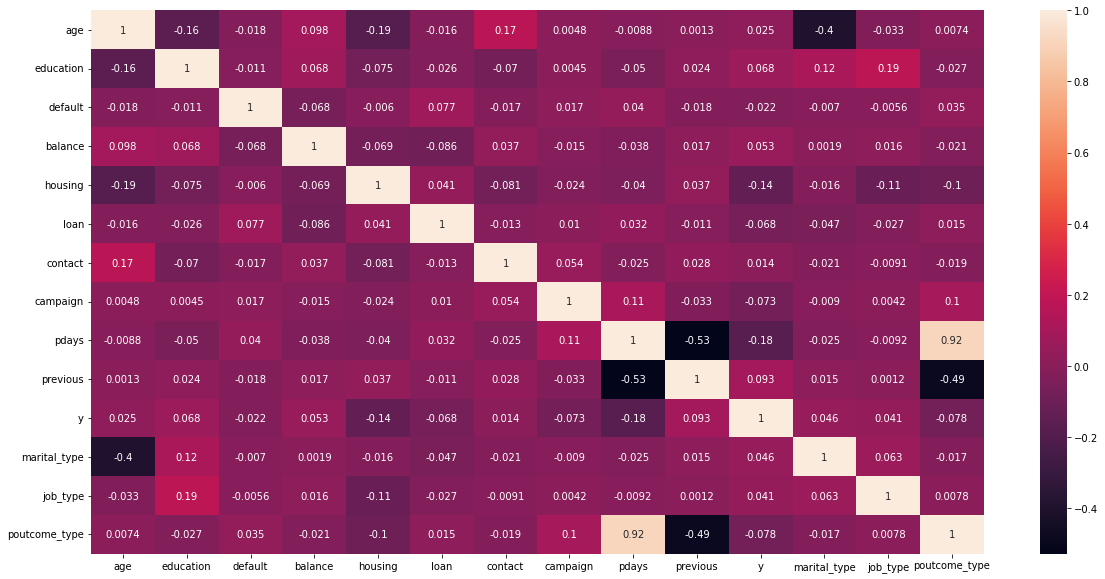

In [70]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(),annot = True)

Seems like nothing highly correlated with subscribed column

# 3.Training :
Lets split the data

In [71]:
y = train.y.to_frame()
X = train.drop(columns = ["y"])
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size = 0.25, random_state = 10)

**LogisticRegression**

In [72]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_predlr = lr.predict(X_test)
cmlr = confusion_matrix(y_test, y_predlr)
acclr = accuracy_score(y_test, y_predlr)
cmlr , acclr

(array([[9880,  112],
        [1116,  195]]),
 0.8913562770945767)

In [73]:
train.shape

(45211, 14)

In [74]:
from tensorflow import keras
from tensorflow.keras import layers

2023-03-17 13:01:22.102119: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-17 13:01:22.173182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-17 13:01:22.173214: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [77]:
ann = keras.Sequential([
  keras.layers.Dense(1024, input_shape=(13,), activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(8, activation='relu'),
  keras.layers.Dense(4, activation='relu'),
  keras.layers.Dense(2, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid'),
])


ann.compile(optimizer='adam', loss = keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

ann.fit(X_train, y_train, epochs=10, batch_size=8)

Epoch 1/10
4239/4239 [==============================] - 14s 3ms/step - loss: 0.3565 - accuracy: 0.8826
Epoch 2/10
4239/4239 [==============================] - 15s 4ms/step - loss: 0.3435 - accuracy: 0.8833
Epoch 3/10
4239/4239 [==============================] - 16s 4ms/step - loss: 0.3384 - accuracy: 0.8827
Epoch 4/10
4239/4239 [==============================] - 16s 4ms/step - loss: 0.3355 - accuracy: 0.8827
Epoch 5/10
4239/4239 [==============================] - 16s 4ms/step - loss: 0.3342 - accuracy: 0.8850
Epoch 6/10
4239/4239 [==============================] - 15s 4ms/step - loss: 0.3310 - accuracy: 0.8893
Epoch 7/10
4239/4239 [==============================] - 16s 4ms/step - loss: 0.3290 - accuracy: 0.8895
Epoch 8/10
4239/4239 [==============================] - 17s 4ms/step - loss: 0.3284 - accuracy: 0.8900
Epoch 9/10
4239/4239 [==============================] - 16s 4ms/step - loss: 0.3281 - accuracy: 0.8905
Epoch 10/10
4239/4239 [==============================] - 16s 4ms/step - l

It's look like we have 90 percent accuracy.But this predictions quite wrong because our accuracy at positive predicted values is : 9885 / (9885 + 107) = 0.99 but our accuracy will be low at negative predicted values: 210 / (1101 + 210) = 0.16. This is happening because we did prediction at imbalanced dataset.Let's balance dataset with SMOTE

# 4.Data Augmentation

In [78]:
sm = SMOTE()
X_sm , y_sm = sm.fit_resample(X, y)
y_sm.y.value_counts()

0    39922
1    39922
Name: y, dtype: int64

# 5.Traning after SMOTE
Data balanced

In [79]:
from sklearn.model_selection import cross_val_score
results = []
X_train_sm , X_test_sm , y_train_sm , y_test_sm = train_test_split(X_sm,y_sm, test_size = 0.25, random_state = 10)
lr2 = LogisticRegression()
lr2.fit(X_train_sm,y_train_sm)
y_predlr2 = lr2.predict(X_test_sm)
cmlr2 = confusion_matrix(y_test_sm, y_predlr2)
acclr2 = accuracy_score(y_test_sm, y_predlr2)
results.append(cross_val_score(lr2, X_train_sm, y_train_sm, cv=5))
cmlr2 , acclr2

(array([[6781, 3181],
        [2936, 7063]]),
 0.6935524272331045)

This time our accuracy around 72 percent. But as you can see our prediction improved at Specificty in confusion matrix.

Support Vector Classifier

In [80]:
svc = SVC()
svc.fit(X_train_sm, y_train_sm)
y_predsvc = svc.predict(X_test_sm)
cmsvc = confusion_matrix(y_test_sm, y_predsvc)
accsvc = accuracy_score(y_test_sm, y_predsvc)
results.append(cross_val_score(svc, X_train_sm, y_train_sm, cv=5))
cmsvc , accsvc

(array([[8392, 1570],
        [6445, 3554]]),
 0.5984670106708081)

In [81]:
knn = KNeighborsClassifier()
knn.fit(X_train_sm, y_train_sm)
y_predknn = knn.predict(X_test_sm)
cmknn = confusion_matrix(y_test_sm, y_predknn)
accknn = accuracy_score(y_test_sm, y_predknn)
results.append(cross_val_score(knn, X_train_sm, y_train_sm, cv=5))
cmknn , accknn

(array([[7084, 2878],
        [ 941, 9058]]),
 0.8086769199939883)

In [82]:
rf = RandomForestClassifier()
rf.fit(X_train_sm, y_train_sm)
y_predrf = rf.predict(X_test_sm)
cmrf = confusion_matrix(y_test_sm, y_predrf)
accrf = accuracy_score(y_test_sm, y_predrf)
results.append(cross_val_score(rf, X_train_sm, y_train_sm, cv=5))
cmrf , accrf

(array([[8218, 1744],
        [1532, 8467]]),
 0.8358799659335705)

In [83]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(n_estimators=150, random_state=0)
ada_clf.fit(X_train_sm, y_train_sm)
y_predada_clf = ada_clf.predict(X_test_sm)
cmada_clf = confusion_matrix(y_test_sm, y_predada_clf)
acc_adaclf = accuracy_score(y_test_sm, y_predada_clf)
results.append(cross_val_score(ada_clf, X_train_sm, y_train_sm, cv=5))
cmada_clf , acc_adaclf

(array([[7340, 2622],
        [2709, 7290]]),
 0.7329292119633285)

In [84]:
from sklearn.ensemble import GradientBoostingClassifier
graclf = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_sm, y_train_sm)
y_pred_graclf = graclf.predict(X_test_sm)
cm_graclf = confusion_matrix(y_test_sm, y_pred_graclf)
acc_graclf = accuracy_score(y_test_sm, y_pred_graclf)
results.append(cross_val_score(graclf, X_train_sm, y_train_sm, cv=5))
cm_graclf , acc_graclf

(array([[7370, 2592],
        [2749, 7250]]),
 0.7324282350583639)

In [85]:
from sklearn.naive_bayes import CategoricalNB
gnb = CategoricalNB()
gnb.fit(X_train_sm, y_train_sm)
y_pred_gnb = gnb.predict(X_test_sm)
cm_gnb = confusion_matrix(y_test_sm, y_pred_gnb)
acc_gnb = accuracy_score(y_test_sm, y_pred_gnb)
results.append(cross_val_score(gnb, X_train_sm, y_train_sm, cv=5))
cm_gnb , acc_gnb

(array([[8022, 1940],
        [4088, 5911]]),
 0.6980111216872902)

In [86]:
len(X_test_sm.columns)

13

In [89]:
from tensorflow import keras
from tensorflow.keras import layers

In [90]:
ann = keras.Sequential([
  keras.layers.Dense(1024, input_shape=(13,), activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(8, activation='relu'),
  keras.layers.Dense(4, activation='relu'),
  keras.layers.Dense(2, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid'),
])

ann.compile(optimizer='adam', loss = keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

ann.fit(X_train_sm, y_train_sm, epochs=10, batch_size=8)

Epoch 1/10
7486/7486 [==============================] - 25s 3ms/step - loss: 0.6932 - accuracy: 0.4970
Epoch 2/10
7486/7486 [==============================] - 28s 4ms/step - loss: 0.6932 - accuracy: 0.4992
Epoch 3/10
7486/7486 [==============================] - 28s 4ms/step - loss: 0.6932 - accuracy: 0.4998
Epoch 4/10
7486/7486 [==============================] - 28s 4ms/step - loss: 0.6932 - accuracy: 0.4997
Epoch 5/10
7486/7486 [==============================] - 29s 4ms/step - loss: 0.6932 - accuracy: 0.4975
Epoch 6/10
7486/7486 [==============================] - 28s 4ms/step - loss: 0.6932 - accuracy: 0.5006
Epoch 7/10
7486/7486 [==============================] - 28s 4ms/step - loss: 0.6931 - accuracy: 0.5033
Epoch 8/10
7486/7486 [==============================] - 28s 4ms/step - loss: 0.6932 - accuracy: 0.4989
Epoch 9/10
7486/7486 [==============================] - 28s 4ms/step - loss: 0.6932 - accuracy: 0.4997
Epoch 10/10
7486/7486 [==============================] - 28s 4ms/step - l

# Trying to replicate logistic regression using keras

In [95]:

logistic = keras.Sequential([
  keras.layers.Dense(1, input_shape=(13,), activation='sigmoid')
])

logistic.compile(optimizer='adam', loss = keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

logistic.fit(X_train_sm, y_train_sm, epochs=10, batch_size=8)

Epoch 1/10
7486/7486 [==============================] - 8s 1ms/step - loss: 5.3564 - accuracy: 0.6214
Epoch 2/10
7486/7486 [==============================] - 6s 867us/step - loss: 0.6151 - accuracy: 0.6688
Epoch 3/10
7486/7486 [==============================] - 6s 846us/step - loss: 0.6091 - accuracy: 0.6776
Epoch 4/10
7486/7486 [==============================] - 6s 824us/step - loss: 0.6081 - accuracy: 0.6763
Epoch 5/10
7486/7486 [==============================] - 7s 948us/step - loss: 0.6068 - accuracy: 0.6781
Epoch 6/10
7486/7486 [==============================] - 7s 920us/step - loss: 0.6045 - accuracy: 0.6816
Epoch 7/10
7486/7486 [==============================] - 8s 1ms/step - loss: 0.6046 - accuracy: 0.6773
Epoch 8/10
7486/7486 [==============================] - 7s 918us/step - loss: 0.6018 - accuracy: 0.6823
Epoch 9/10
7486/7486 [==============================] - 7s 885us/step - loss: 0.6034 - accuracy: 0.6784
Epoch 10/10
7486/7486 [==============================] - 8s 1ms/step

In [91]:
ann

LogisticRegression()

In [61]:
results[-1]

array([       nan,        nan,        nan, 0.71200735, 0.71442886])

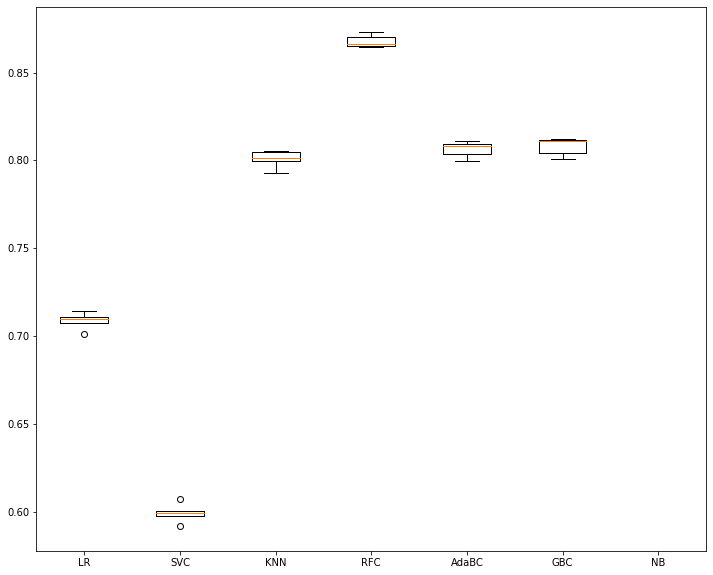

In [59]:
import matplotlib.pyplot as plt

names = ["LR", "SVC", "KNN","RFC", "AdaBC", "GBC", "NB"]

fig = plt.figure(figsize=(12,10))
ax=plt.axes()
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

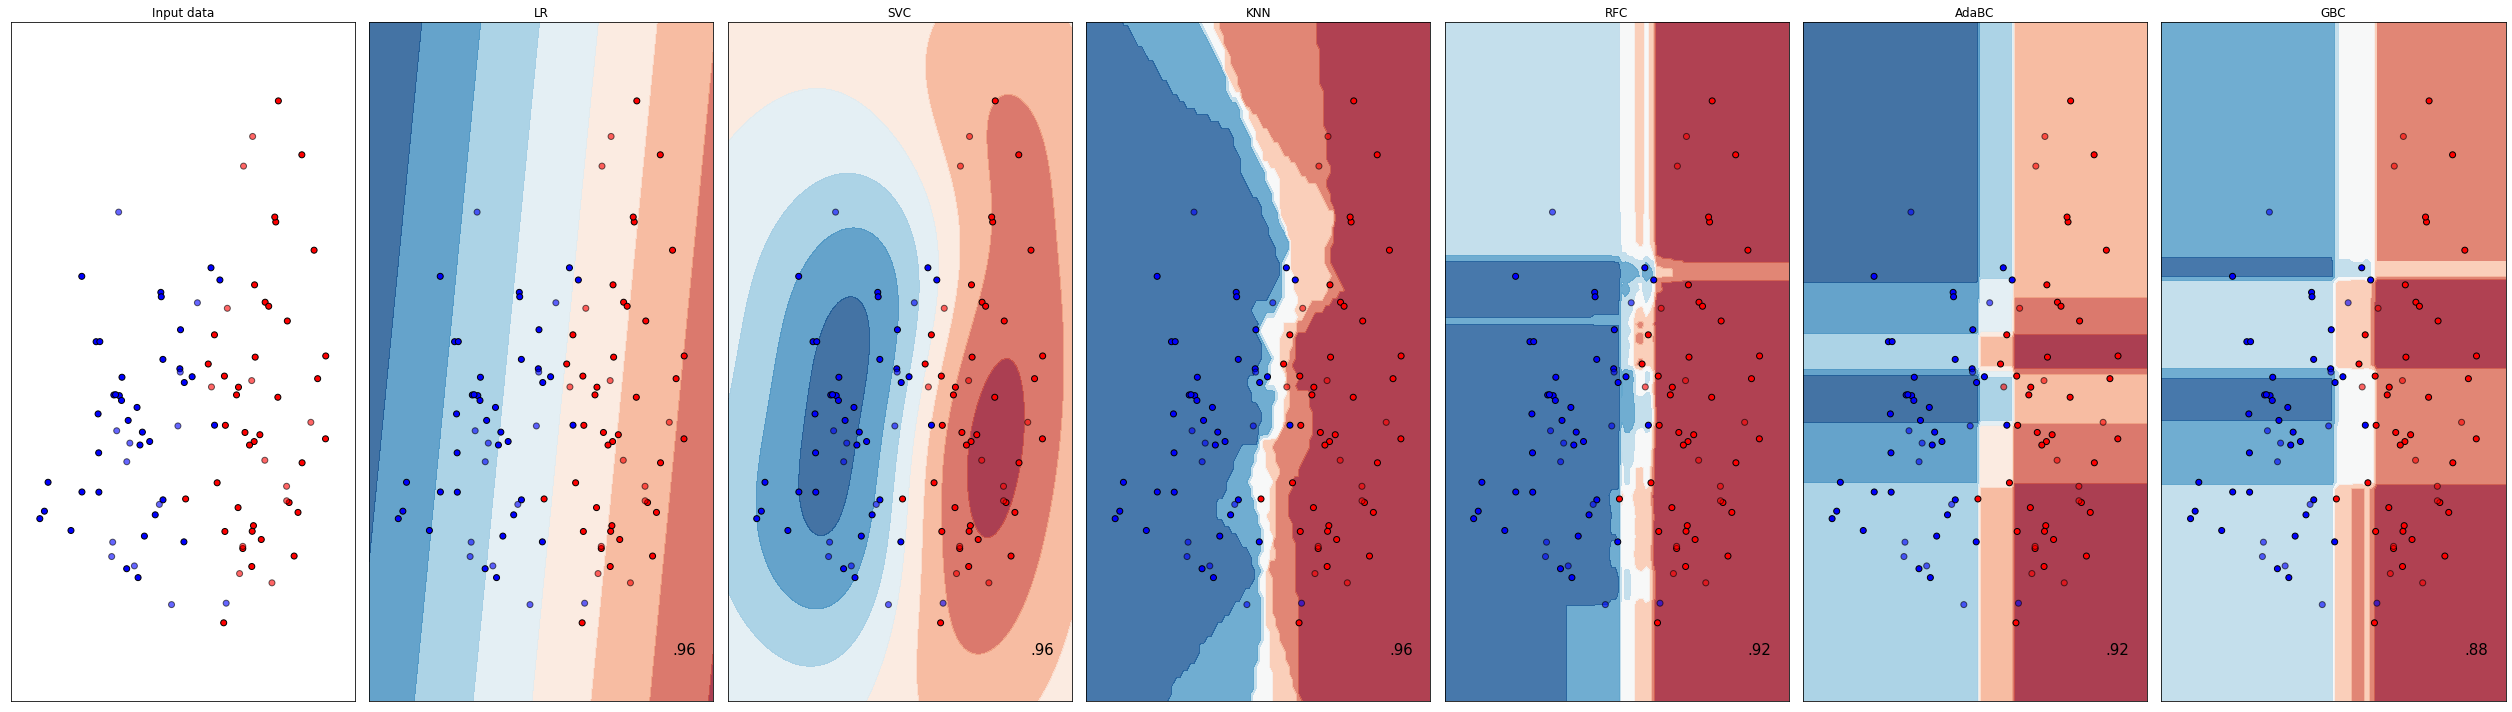

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

names = ["LR", "SVC", "KNN","RFC", "AdaBC", "GBC"]

classifiers = [
    LogisticRegression(),
    SVC(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(n_estimators=150, random_state=0),
    GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, max_depth=1, random_state=0),
]

datasets = [
    train,
]

figure = plt.figure(figsize=(35, 10), facecolor="white")
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()
